In [ ]:
!pip uninstall transformers torch torchaudio torchvision wandb -y

Found existing installation: transformers 4.57.2
Uninstalling transformers-4.57.2:
  Successfully uninstalled transformers-4.57.2
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: wandb 0.23.0
Uninstalling wandb-0.23.0:
  Successfully uninstalled wandb-0.23.0


In [ ]:
%%capture
!pip install llmcompressor
!pip install -q accelerate bitsandbytes datasets scipy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset
import copy
import gc
from tqdm import tqdm
from transformers import AwqConfig
import shutil
from llmcompressor import oneshot
from llmcompressor.modifiers.quantization import GPTQModifier
from llmcompressor.modifiers.awq import AWQModifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import random
import numpy as np
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
TEST_RUN = True

if TEST_RUN:
  # Model & Data
  MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
  tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
  calib_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
  calib_input = tokenizer("\n\n".join(calib_dataset["text"][:10]), return_tensors="pt").input_ids[:, :512].to(device)

  NUM_EVAL_SAMPLES = 200
  MMLU_SUBSET = ["elementary_mathematics"]
  list_of_datasets = [
    load_dataset("cais/mmlu", subset, split='test')
    for subset in MMLU_SUBSET
  ]
  mmlu_dataset = concatenate_datasets(list_of_datasets)
  results = {}
else:
  MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
  mmlu_dataset = load_dataset("cais/mmlu", split="test")
  results = {}

In [ ]:
# Helper Functions
def compute_kld(logits_p, logits_q):
    """KL Divergence: P=Baseline, Q=Quantized"""
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def format_mmlu_prompt(example):
    options = [f"{label}. {example['choices'][i]}" for i, label in enumerate(['A', 'B', 'C', 'D'])]
    prompt_text = f"Question: {example['question']}\nOptions:\n" + "\n".join(options) + "\nAnswer:"
    messages = [
        {"role": "system", "content": "Output only the single letter (A, B, C, or D) corresponding to the correct answer."},
        {"role": "user", "content": prompt_text}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def get_mmlu_predictions(model, dataset, num_samples):
    predictions, ground_truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    print(f"Evaluating {num_samples} samples...")
    for i in tqdm(range(num_samples)):
        ex = dataset[i]
        inputs = tokenizer(format_mmlu_prompt(ex), return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]
        predictions.append(pred)
        ground_truths.append(choices[ex['answer']])
    return predictions, ground_truths

def fake_quantize_tensor_rtn(w):
    """
    Round-To-Nearest (RTN) simulation.
    We ONLY use this for PROFILING sensitivity, not for the final model.
    """
    bits = 4
    max_val = w.abs().max()
    scale = max_val / (2**(bits-1) - 1)
    return (w / scale).round().clamp(-8, 7) * scale

def eval_and_record(model, name):
    preds, _ = get_mmlu_predictions(model, mmlu_dataset, NUM_EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, ground_truths) if p == g]) / len(ground_truths)
    flips = sum([1 for b, q in zip(base_preds, preds) if b != q])
    rate = flips / len(base_preds)
    results[name] = {"Acc": acc, "Flip": rate}
    print(f"{name} -> Acc: {acc:.2%}, Flip: {rate:.2%}")

In [ ]:
# Profiling & Baseline (FP16)
print("--- 1. Loading FP16 Model for Profiling ---")
model_fp16 = AutoModelForCausalLM.from_pretrained(MODEL_ID, dtype=torch.float16, device_map="auto")

# A. Compute Baseline MMLU (Ground Truth for Flips)
print("Computing FP16 Baseline predictions...")
base_preds, ground_truths = get_mmlu_predictions(model_fp16, mmlu_dataset, NUM_EVAL_SAMPLES)
base_acc = sum([1 for p, g in zip(base_preds, ground_truths) if p == g]) / len(ground_truths)
print(f"Baseline Accuracy: {base_acc:.2%}")

results['FP16 Baseline'] = {'Acc': base_acc, 'Flip': 0.0}

# B. Profile Sensitivity (Using RTN Proxy)
# Note: We use RTN to *find* sensitive layers. We will use NF4 to *quantize* the others.
print("Profiling Layer Sensitivity...")
with torch.no_grad():
    base_logits = model_fp16(calib_input).logits

linear_layers = {name: m for name, m in model_fp16.named_modules() if isinstance(m, nn.Linear)}
sensitivity_scores = {}

for name, layer in tqdm(linear_layers.items()):
    original_weight = layer.weight.data.clone()
    # Perturb with RTN
    layer.weight.data = fake_quantize_tensor_rtn(original_weight)

    with torch.no_grad():
        kld = compute_kld(base_logits, model_fp16(calib_input).logits)
        sensitivity_scores[name] = kld

    # Restore
    layer.weight.data = original_weight

# Identify Top 5% Sensitive Layers
sorted_layers = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)
KEEP_RATIO = 0.05
sensitive_layer_names = set([n for n, s in sorted_layers[:int(len(sorted_layers)*KEEP_RATIO)]])
print(f"Identified {len(sensitive_layer_names)} sensitive layers to keep in FP16.")

# Important: We must KEEP model_fp16 in memory (or cpu) to extract weights later
# Move to CPU to save GPU RAM for the next models
model_fp16.cpu()
torch.cuda.empty_cache()

--- 1. Loading FP16 Model for Profiling ---


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Computing FP16 Baseline predictions...
Evaluating 200 samples...


100%|██████████| 200/200 [00:07<00:00, 26.97it/s]


Baseline Accuracy: 25.00%
Profiling Layer Sensitivity...


100%|██████████| 169/169 [00:09<00:00, 18.13it/s]


Identified 8 sensitive layers to keep in FP16.


In [ ]:
# --- Helper: Recursive Attribute Access ---
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

# --- Helper: Surgery Function (Reusable) ---
def perform_surgery(model, sensitive_names, fp16_model_cpu):
    """
    Replaces the sensitive quantized layers in 'model' (GPU)
    with the original FP16 layers from 'fp16_model_cpu' (CPU).
    """
    count = 0
    print(f"Surgery: Replacing {len(sensitive_names)} Sensitive Layers with FP16...")

    for name in sensitive_names:
        try:
            # 1. Get original FP16 weight from CPU backup
            original_layer = recursive_getattr(fp16_model_cpu, name)

            # 2. Create new Linear layer on GPU
            new_layer = nn.Linear(
                in_features=original_layer.in_features,
                out_features=original_layer.out_features,
                bias=(original_layer.bias is not None)
            )
            new_layer.weight.data = original_layer.weight.data.to(model.device)
            if original_layer.bias is not None:
                new_layer.bias.data = original_layer.bias.data.to(model.device)

            # 3. Swap into the quantized model
            recursive_setattr(model, name, new_layer)
            count += 1
        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

In [ ]:
# --- Evaluation Pipeline ---
# --- Prepare Calibration Data ---
print("Preparing calibration data...")
if 'calib_dataset' in globals():
    raw_calib_data = [text for text in calib_dataset["text"] if len(text) > 0][:128]
else:
    from datasets import load_dataset
    ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    raw_calib_data = [text for text in ds["text"] if len(text) > 0][:128]

# ==========================================
# 1. LLM.int8() Pair
# ==========================================
print("\n" + "="*50)
print("--- 1. Evaluating LLM.int8 Pair ---")
print("="*50)

model_int8 = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, load_in_8bit=True, device_map="auto"
)
eval_and_record(model_int8, "LLM.int8()")

# KLD Surgery
perform_surgery(model_int8, sensitive_layer_names, model_fp16)
eval_and_record(model_int8, "KLD-LLM.int8()")

del model_int8
torch.cuda.empty_cache()
gc.collect()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Preparing calibration data...

--- 1. Evaluating LLM.int8 Pair ---
Evaluating 200 samples...


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


LLM.int8() -> Acc: 26.00%, Flip: 19.00%
Surgery: Replacing 8 Sensitive Layers with FP16...
Surgery Complete: 8 layers restored.
Evaluating 200 samples...


100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


KLD-LLM.int8() -> Acc: 25.00%, Flip: 15.50%


34

In [ ]:
# ==========================================
# 2. NF4 Pair
# ==========================================
print("\n" + "="*50)
print("--- 2. Evaluating NF4 Pair ---")
print("="*50)

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
model_nf4 = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, quantization_config=nf4_config, device_map="auto"
)
eval_and_record(model_nf4, "NF4 (Standard)")

# KLD Surgery
perform_surgery(model_nf4, sensitive_layer_names, model_fp16)
eval_and_record(model_nf4, "KLD-NF4()")

del model_nf4
torch.cuda.empty_cache()
gc.collect()


--- 2. Evaluating NF4 Pair ---
Evaluating 200 samples...


100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


NF4 (Standard) -> Acc: 26.50%, Flip: 63.00%
Surgery: Replacing 8 Sensitive Layers with FP16...
Surgery Complete: 8 layers restored.
Evaluating 200 samples...


100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


KLD-NF4() -> Acc: 28.00%, Flip: 43.00%


3694

In [ ]:
# ==========================================
# 3. AWQ Pair (via llmcompressor)
# ==========================================
print("\n" + "="*50)
print("--- 3. Evaluating AWQ Pair (llmcompressor) ---")
print("="*50)

# llmcompressor expects a HF Dataset object
calib_dataset_obj = Dataset.from_dict({"text": raw_calib_data})

# Define Recipe for AWQ
recipe_awq = [
    AWQModifier(
        targets="Linear",
        scheme="W4A16"  # 4-bit weights, 16-bit activations
        # Removed: start_step=0, as it's not a valid argument
    )
]

# Run Oneshot Quantization
# Note: llmcompressor handles loading the model internally for oneshot
print("Running AWQ Quantization...")
oneshot(
    model=MODEL_ID,
    dataset=calib_dataset_obj,
    recipe=recipe_awq,
    output_dir="./awq_llmcompressor_temp",
    num_calibration_samples=len(raw_calib_data),
    max_seq_length=512,
    save_compressed=True
)

# Load the saved quantized model
model_awq = AutoModelForCausalLM.from_pretrained(
    "./awq_llmcompressor_temp", device_map="auto", trust_remote_code=True
)
eval_and_record(model_awq, "AWQ (Standard)")

# KLD Surgery
perform_surgery(model_awq, sensitive_layer_names, model_fp16)
eval_and_record(model_awq, "KLD-AWQ()")

del model_awq
shutil.rmtree("./awq_llmcompressor_temp") # Clean up disk
torch.cuda.empty_cache()
gc.collect()

`torch_dtype` is deprecated! Use `dtype` instead!



--- 3. Evaluating AWQ Pair (llmcompressor) ---
Running AWQ Quantization...


Tokenizing:   0%|          | 0/128 [00:00<?, ? examples/s]

2025-12-02T23:08:39.308441+0000 | reset | INFO - Compression lifecycle reset
2025-12-02T23:08:39.316936+0000 | _create_default_logger | INFO - Logging all LLM Compressor modifier-level logs to sparse_logs/02-12-2025_23.08.39.log
2025-12-02T23:08:39.318178+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-12-02T23:08:39.347148+0000 | on_initialize | INFO - No AWQModifier.mappings provided, inferring from model...


Resolving mapping 1/4 (0 skipped): : 24it [00:00, 1074.75it/s]
Resolving mapping 2/4 (23 skipped): : 24it [00:00, 1698.96it/s]
Resolving mapping 3/4 (0 skipped): : 24it [00:00, 1220.07it/s]
Resolving mapping 4/4 (0 skipped): : 24it [00:00, 1603.35it/s]

2025-12-02T23:08:39.428552+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers
2025-12-02T23:08:39.429216+0000 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `AWQModifier`



(25/25): Calibrating: 100%|██████████| 128/128 [00:08<00:00, 15.98it/s]
Smoothing: 0it [00:00, ?it/s]
(25/25): Propagating: 100%|██████████| 128/128 [00:08<00:00, 15.98it/s]
Smoothing: 0it [00:00, ?it/s]
Calibrating weights: 169it [00:01, 145.74it/s]

2025-12-02T23:19:49.745712+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers
2025-12-02T23:19:49.788278+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.



Compressing model: 169it [00:01, 104.29it/s]
Compressing model: 169it [00:00, 1168.72it/s]


Evaluating 200 samples...


100%|██████████| 200/200 [00:24<00:00,  8.25it/s]


AWQ (Standard) -> Acc: 29.50%, Flip: 79.00%
Surgery: Replacing 8 Sensitive Layers with FP16...
Surgery Complete: 8 layers restored.
Evaluating 200 samples...


100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


KLD-AWQ() -> Acc: 20.50%, Flip: 42.00%


7848

In [ ]:
# ==========================================
# 4. GPTQ Pair (via llmcompressor)
# ==========================================
print("\n" + "="*50)
print("--- 4. Evaluating GPTQ Pair (llmcompressor) ---")
print("="*50)

# Define Recipe for GPTQ
recipe_gptq = [
    GPTQModifier(
        targets="Linear",
        scheme="W4A16",
        ignore=["lm_head"],
        dampening_frac=0.01  # Standard value
    )
]

# Run Oneshot Quantization
print("Running GPTQ Quantization...")
oneshot(
    model=MODEL_ID,
    dataset=calib_dataset_obj,
    recipe=recipe_gptq,
    output_dir="./gptq_llmcompressor_temp",
    num_calibration_samples=len(raw_calib_data),
    max_seq_length=512,
    save_compressed=True
)

# Load the saved quantized model
model_gptq = AutoModelForCausalLM.from_pretrained(
    "./gptq_llmcompressor_temp", device_map="auto", trust_remote_code=True
)
eval_and_record(model_gptq, "GPTQ (Standard)")

# KLD Surgery
perform_surgery(model_gptq, sensitive_layer_names, model_fp16)
eval_and_record(model_gptq, "KLD-GPTQ()")

del model_gptq
shutil.rmtree("./gptq_llmcompressor_temp")
torch.cuda.empty_cache()
gc.collect()


--- 4. Evaluating GPTQ Pair (llmcompressor) ---
Running GPTQ Quantization...


Tokenizing:   0%|          | 0/128 [00:00<?, ? examples/s]

2025-12-02T23:20:40.487947+0000 | reset | INFO - Compression lifecycle reset
2025-12-02T23:20:40.490465+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-12-02T23:20:40.521637+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers
2025-12-02T23:20:40.522375+0000 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `GPTQModifier`


(1/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 47.42it/s]

2025-12-02T23:20:44.301423+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.q_proj using 128 samples


2025-12-02T23:20:44.861000+0000 | compress | METRIC - time 0.56s
2025-12-02T23:20:44.862244+0000 | compress | METRIC - error 22.05
2025-12-02T23:20:44.863665+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:20:44.864359+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:20:44.865582+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.k_proj using 128 samples
2025-12-02T23:20:45.372110+0000 | compress | METRIC - time 0.51s
2025-12-02T23:20:45.373319+0000 | compress | METRIC - error 3.37
2025-12-02T23:20:45.374414+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:20:45.375495+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:20:45.376429+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.v_proj using 128 samples
2025-12-02T23:20:45.860937+0000 | compress | METRIC - time 0.48s
2025-12-02T23:20:45.861886+0000 | compress | METRIC - erro

(2/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.13it/s]

2025-12-02T23:20:54.351328+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.q_proj using 128 samples


2025-12-02T23:20:54.842572+0000 | compress | METRIC - time 0.49s
2025-12-02T23:20:54.843629+0000 | compress | METRIC - error 147.03
2025-12-02T23:20:54.844379+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:20:54.844987+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:20:54.846225+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.k_proj using 128 samples
2025-12-02T23:20:55.307289+0000 | compress | METRIC - time 0.46s
2025-12-02T23:20:55.308355+0000 | compress | METRIC - error 41.03
2025-12-02T23:20:55.309266+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:20:55.310074+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:20:55.311003+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.v_proj using 128 samples
2025-12-02T23:20:55.768613+0000 | compress | METRIC - time 0.46s
2025-12-02T23:20:55.769849+0000 | compress | METRIC - er

(3/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.31it/s]

2025-12-02T23:21:03.327660+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.q_proj using 128 samples


2025-12-02T23:21:03.812928+0000 | compress | METRIC - time 0.48s
2025-12-02T23:21:03.814260+0000 | compress | METRIC - error 351.48
2025-12-02T23:21:03.815006+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:03.815695+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:03.816841+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.k_proj using 128 samples
2025-12-02T23:21:04.270077+0000 | compress | METRIC - time 0.45s
2025-12-02T23:21:04.271130+0000 | compress | METRIC - error 96.04
2025-12-02T23:21:04.271981+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:04.272720+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:04.273818+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.v_proj using 128 samples
2025-12-02T23:21:04.748979+0000 | compress | METRIC - time 0.47s
2025-12-02T23:21:04.750465+0000 | compress | METRIC - er

(4/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 54.88it/s]

2025-12-02T23:21:12.321511+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.q_proj using 128 samples


2025-12-02T23:21:12.804671+0000 | compress | METRIC - time 0.48s
2025-12-02T23:21:12.806153+0000 | compress | METRIC - error 462.19
2025-12-02T23:21:12.807087+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:12.807940+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:12.808967+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.k_proj using 128 samples
2025-12-02T23:21:13.269901+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:13.271150+0000 | compress | METRIC - error 109.44
2025-12-02T23:21:13.271813+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:13.272801+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:13.273843+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.v_proj using 128 samples
2025-12-02T23:21:13.739717+0000 | compress | METRIC - time 0.47s
2025-12-02T23:21:13.740894+0000 | compress | METRIC - e

(5/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 53.09it/s]

2025-12-02T23:21:21.493840+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.q_proj using 128 samples


2025-12-02T23:21:21.969583+0000 | compress | METRIC - time 0.47s
2025-12-02T23:21:21.970786+0000 | compress | METRIC - error 401.26
2025-12-02T23:21:21.971517+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:21.972385+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:21.973610+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.k_proj using 128 samples
2025-12-02T23:21:22.438379+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:22.439784+0000 | compress | METRIC - error 80.10
2025-12-02T23:21:22.440669+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:22.441620+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:22.442458+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.v_proj using 128 samples
2025-12-02T23:21:22.894300+0000 | compress | METRIC - time 0.45s
2025-12-02T23:21:22.895427+0000 | compress | METRIC - er

(6/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 51.28it/s]

2025-12-02T23:21:30.612281+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.q_proj using 128 samples


2025-12-02T23:21:31.096272+0000 | compress | METRIC - time 0.48s
2025-12-02T23:21:31.097689+0000 | compress | METRIC - error 523.95
2025-12-02T23:21:31.098593+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:31.099581+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:31.100494+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.k_proj using 128 samples
2025-12-02T23:21:31.559228+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:31.560546+0000 | compress | METRIC - error 104.69
2025-12-02T23:21:31.561277+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:31.561896+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:31.562837+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.v_proj using 128 samples
2025-12-02T23:21:32.020147+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:32.021446+0000 | compress | METRIC - e

(7/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 50.24it/s]

2025-12-02T23:21:39.836405+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.q_proj using 128 samples


2025-12-02T23:21:40.356355+0000 | compress | METRIC - time 0.52s
2025-12-02T23:21:40.358097+0000 | compress | METRIC - error 481.02
2025-12-02T23:21:40.359336+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:40.360273+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:40.361167+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.k_proj using 128 samples
2025-12-02T23:21:40.823587+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:40.824971+0000 | compress | METRIC - error 109.29
2025-12-02T23:21:40.825690+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:40.826608+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:40.827577+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.v_proj using 128 samples
2025-12-02T23:21:41.279841+0000 | compress | METRIC - time 0.45s
2025-12-02T23:21:41.281033+0000 | compress | METRIC - e

(8/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 50.84it/s]

2025-12-02T23:21:49.037945+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.q_proj using 128 samples


2025-12-02T23:21:49.508811+0000 | compress | METRIC - time 0.47s
2025-12-02T23:21:49.510097+0000 | compress | METRIC - error 661.70
2025-12-02T23:21:49.510828+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:49.511489+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:49.512622+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.k_proj using 128 samples
2025-12-02T23:21:49.972743+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:49.974080+0000 | compress | METRIC - error 162.49
2025-12-02T23:21:49.974684+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:49.975689+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:49.976886+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.v_proj using 128 samples
2025-12-02T23:21:50.439103+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:50.440543+0000 | compress | METRIC - e

(9/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 51.55it/s]

2025-12-02T23:21:58.178976+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.q_proj using 128 samples


2025-12-02T23:21:58.653489+0000 | compress | METRIC - time 0.47s
2025-12-02T23:21:58.654591+0000 | compress | METRIC - error 728.41
2025-12-02T23:21:58.655670+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:58.656479+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:21:58.657635+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.k_proj using 128 samples
2025-12-02T23:21:59.122727+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:59.124047+0000 | compress | METRIC - error 134.15
2025-12-02T23:21:59.124913+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:21:59.125960+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:21:59.127029+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.v_proj using 128 samples
2025-12-02T23:21:59.586536+0000 | compress | METRIC - time 0.46s
2025-12-02T23:21:59.587541+0000 | compress | METRIC - e

(10/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 53.91it/s]

2025-12-02T23:22:07.205816+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.q_proj using 128 samples


2025-12-02T23:22:07.672943+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:07.673988+0000 | compress | METRIC - error 1282.41
2025-12-02T23:22:07.674974+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:07.675889+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:07.676765+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.k_proj using 128 samples
2025-12-02T23:22:08.134754+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:08.135922+0000 | compress | METRIC - error 310.98
2025-12-02T23:22:08.136765+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:08.137602+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:08.138749+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.v_proj using 128 samples
2025-12-02T23:22:08.597557+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:08.598752+0000 | compress | METRIC - 

(11/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 54.66it/s]

2025-12-02T23:22:16.131660+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.q_proj using 128 samples


2025-12-02T23:22:16.609396+0000 | compress | METRIC - time 0.48s
2025-12-02T23:22:16.610698+0000 | compress | METRIC - error 609.65
2025-12-02T23:22:16.611533+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:16.612365+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:16.613409+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.k_proj using 128 samples
2025-12-02T23:22:17.069879+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:17.071247+0000 | compress | METRIC - error 115.30
2025-12-02T23:22:17.072046+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:17.072966+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:17.073953+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.v_proj using 128 samples
2025-12-02T23:22:17.530523+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:17.531776+0000 | compress | METRIC -

(12/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 54.99it/s]

2025-12-02T23:22:25.115179+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.q_proj using 128 samples


2025-12-02T23:22:25.595524+0000 | compress | METRIC - time 0.48s
2025-12-02T23:22:25.597025+0000 | compress | METRIC - error 1376.24
2025-12-02T23:22:25.597823+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:25.598575+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:25.600056+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.k_proj using 128 samples
2025-12-02T23:22:26.068398+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:26.069608+0000 | compress | METRIC - error 359.11
2025-12-02T23:22:26.070577+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:26.071457+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:26.072586+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.v_proj using 128 samples
2025-12-02T23:22:26.538851+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:26.540108+0000 | compress | METRIC 

(13/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 54.07it/s]

2025-12-02T23:22:34.074426+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.q_proj using 128 samples


2025-12-02T23:22:34.544237+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:34.545410+0000 | compress | METRIC - error 625.59
2025-12-02T23:22:34.546443+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:34.547333+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:34.548234+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.k_proj using 128 samples
2025-12-02T23:22:35.002289+0000 | compress | METRIC - time 0.45s
2025-12-02T23:22:35.003622+0000 | compress | METRIC - error 112.15
2025-12-02T23:22:35.004414+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:35.004877+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:35.005946+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.v_proj using 128 samples
2025-12-02T23:22:35.454335+0000 | compress | METRIC - time 0.45s
2025-12-02T23:22:35.455648+0000 | compress | METRIC -

(14/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.68it/s]

2025-12-02T23:22:43.141588+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.q_proj using 128 samples


2025-12-02T23:22:43.612059+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:43.613174+0000 | compress | METRIC - error 983.81
2025-12-02T23:22:43.614165+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:43.615039+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:43.616101+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.k_proj using 128 samples
2025-12-02T23:22:44.071765+0000 | compress | METRIC - time 0.45s
2025-12-02T23:22:44.072943+0000 | compress | METRIC - error 191.87
2025-12-02T23:22:44.073647+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:44.074369+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:44.075428+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.v_proj using 128 samples
2025-12-02T23:22:44.539881+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:44.541035+0000 | compress | METRIC -

(15/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 50.90it/s]

2025-12-02T23:22:52.283691+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.q_proj using 128 samples


2025-12-02T23:22:52.756861+0000 | compress | METRIC - time 0.47s
2025-12-02T23:22:52.758293+0000 | compress | METRIC - error 866.61
2025-12-02T23:22:52.759244+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:52.760026+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:22:52.761178+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.k_proj using 128 samples
2025-12-02T23:22:53.219233+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:53.220621+0000 | compress | METRIC - error 134.92
2025-12-02T23:22:53.221428+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:22:53.222642+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:22:53.223885+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.v_proj using 128 samples
2025-12-02T23:22:53.686135+0000 | compress | METRIC - time 0.46s
2025-12-02T23:22:53.687412+0000 | compress | METRIC -

(16/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 51.38it/s]

2025-12-02T23:23:01.441969+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.q_proj using 128 samples


2025-12-02T23:23:01.923642+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:01.924860+0000 | compress | METRIC - error 728.94
2025-12-02T23:23:01.925641+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:01.926369+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:01.927279+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.k_proj using 128 samples
2025-12-02T23:23:02.385905+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:02.387057+0000 | compress | METRIC - error 139.69
2025-12-02T23:23:02.387772+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:02.388855+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:02.389910+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.v_proj using 128 samples
2025-12-02T23:23:02.850034+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:02.851418+0000 | compress | METRIC -

(17/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.17it/s]

2025-12-02T23:23:10.520394+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.q_proj using 128 samples


2025-12-02T23:23:11.015342+0000 | compress | METRIC - time 0.49s
2025-12-02T23:23:11.016626+0000 | compress | METRIC - error 1373.68
2025-12-02T23:23:11.017581+0000 | compress | METRIC - GPU 0 | usage: 11.67% | total memory: 16 GB
2025-12-02T23:23:11.018333+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:11.019457+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.k_proj using 128 samples
2025-12-02T23:23:11.476682+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:11.477877+0000 | compress | METRIC - error 237.98
2025-12-02T23:23:11.479015+0000 | compress | METRIC - GPU 0 | usage: 11.67% | total memory: 16 GB
2025-12-02T23:23:11.480061+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:11.481072+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.v_proj using 128 samples
2025-12-02T23:23:11.962304+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:11.963808+0000 | compress | METRIC 

(18/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.88it/s]

2025-12-02T23:23:19.638539+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.q_proj using 128 samples


2025-12-02T23:23:20.115148+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:20.116588+0000 | compress | METRIC - error 983.04
2025-12-02T23:23:20.117335+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:20.118375+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:20.119422+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.k_proj using 128 samples
2025-12-02T23:23:20.578006+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:20.579250+0000 | compress | METRIC - error 145.93
2025-12-02T23:23:20.580076+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:20.580688+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:20.581769+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.v_proj using 128 samples
2025-12-02T23:23:21.041551+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:21.043101+0000 | compress | METRIC -

(19/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.78it/s]

2025-12-02T23:23:28.718966+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.q_proj using 128 samples


2025-12-02T23:23:29.191166+0000 | compress | METRIC - time 0.47s
2025-12-02T23:23:29.192606+0000 | compress | METRIC - error 988.10
2025-12-02T23:23:29.193375+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:29.194083+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:29.195038+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.k_proj using 128 samples
2025-12-02T23:23:29.647752+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:29.649176+0000 | compress | METRIC - error 181.67
2025-12-02T23:23:29.650087+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:29.650780+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:29.651816+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.v_proj using 128 samples
2025-12-02T23:23:30.107250+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:30.108655+0000 | compress | METRIC -

(20/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 53.54it/s]

2025-12-02T23:23:37.759717+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.q_proj using 128 samples


2025-12-02T23:23:38.241876+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:38.243241+0000 | compress | METRIC - error 863.23
2025-12-02T23:23:38.244071+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:38.244916+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:38.245867+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.k_proj using 128 samples
2025-12-02T23:23:38.698861+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:38.700444+0000 | compress | METRIC - error 142.40
2025-12-02T23:23:38.701268+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:38.702150+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:38.703083+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.v_proj using 128 samples
2025-12-02T23:23:39.154715+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:39.156184+0000 | compress | METRIC -

(21/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.64it/s]

2025-12-02T23:23:46.776628+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.q_proj using 128 samples


2025-12-02T23:23:47.256246+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:47.257543+0000 | compress | METRIC - error 1270.12
2025-12-02T23:23:47.258286+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:47.259139+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:47.260100+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.k_proj using 128 samples
2025-12-02T23:23:47.713519+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:47.714882+0000 | compress | METRIC - error 182.46
2025-12-02T23:23:47.715650+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:47.716827+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:47.717698+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.v_proj using 128 samples
2025-12-02T23:23:48.166146+0000 | compress | METRIC - time 0.45s
2025-12-02T23:23:48.167482+0000 | compress | METRIC 

(22/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 52.01it/s]

2025-12-02T23:23:55.857061+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.q_proj using 128 samples


2025-12-02T23:23:56.343467+0000 | compress | METRIC - time 0.48s
2025-12-02T23:23:56.344798+0000 | compress | METRIC - error 1525.14
2025-12-02T23:23:56.345865+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:56.346651+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:23:56.347793+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.k_proj using 128 samples
2025-12-02T23:23:56.809234+0000 | compress | METRIC - time 0.46s
2025-12-02T23:23:56.810492+0000 | compress | METRIC - error 203.87
2025-12-02T23:23:56.811586+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:23:56.812572+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:23:56.813587+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.v_proj using 128 samples
2025-12-02T23:23:57.303102+0000 | compress | METRIC - time 0.49s
2025-12-02T23:23:57.304422+0000 | compress | METRIC 

(23/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 51.98it/s]

2025-12-02T23:24:05.077065+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.q_proj using 128 samples


2025-12-02T23:24:05.555262+0000 | compress | METRIC - time 0.48s
2025-12-02T23:24:05.556625+0000 | compress | METRIC - error 1342.50
2025-12-02T23:24:05.557319+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:24:05.557850+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:24:05.559005+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.k_proj using 128 samples
2025-12-02T23:24:06.012674+0000 | compress | METRIC - time 0.45s
2025-12-02T23:24:06.013920+0000 | compress | METRIC - error 178.34
2025-12-02T23:24:06.014859+0000 | compress | METRIC - GPU 0 | usage: 11.65% | total memory: 16 GB
2025-12-02T23:24:06.015740+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:24:06.016848+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.v_proj using 128 samples
2025-12-02T23:24:06.463785+0000 | compress | METRIC - time 0.45s
2025-12-02T23:24:06.465004+0000 | compress | METRIC 

(24/25): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 53.00it/s]

2025-12-02T23:24:14.138116+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.q_proj using 128 samples


2025-12-02T23:24:14.615246+0000 | compress | METRIC - time 0.48s
2025-12-02T23:24:14.616455+0000 | compress | METRIC - error 1659.19
2025-12-02T23:24:14.617262+0000 | compress | METRIC - GPU 0 | usage: 11.67% | total memory: 16 GB
2025-12-02T23:24:14.617792+0000 | compress | METRIC - Compressed module size: 1.62624 MB
2025-12-02T23:24:14.619030+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.k_proj using 128 samples
2025-12-02T23:24:15.073761+0000 | compress | METRIC - time 0.45s
2025-12-02T23:24:15.075093+0000 | compress | METRIC - error 213.45
2025-12-02T23:24:15.075993+0000 | compress | METRIC - GPU 0 | usage: 11.67% | total memory: 16 GB
2025-12-02T23:24:15.076886+0000 | compress | METRIC - Compressed module size: 0.23232 MB
2025-12-02T23:24:15.077853+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.v_proj using 128 samples
2025-12-02T23:24:15.527029+0000 | compress | METRIC - time 0.45s
2025-12-02T23:24:15.528388+0000 | compress | METRIC 

(25/25): Propagating: 100%|██████████| 128/128 [00:08<00:00, 15.20it/s]


2025-12-02T23:24:37.702307+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers
2025-12-02T23:24:37.742155+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Compressing model: 168it [00:01, 149.14it/s]
Compressing model: 168it [00:00, 1172.72it/s]


Evaluating 200 samples...


100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


GPTQ (Standard) -> Acc: 27.00%, Flip: 39.50%
Surgery: Replacing 8 Sensitive Layers with FP16...
Surgery Complete: 8 layers restored.
Evaluating 200 samples...


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


KLD-GPTQ() -> Acc: 24.50%, Flip: 44.00%


8164

In [ ]:
# --- Final Summary Table ---
print("\n" + "="*60)
print(f"{'Method':<25} | {'Acc':<10} | {'Flip Rate':<10}")
print("-" * 60)
order = [
    "FP16 Baseline",
    "LLM.int8()", "KLD-LLM.int8()",
    "NF4 (Standard)", "KLD-NF4()",
    "AWQ (Standard)", "KLD-AWQ()",
    "GPTQ (Standard)", "KLD-GPTQ()"
]
for m in order:
    if m in results:
        v = results[m]
        print(f"{m:<25} | {v['Acc']:<10.2%} | {v['Flip']:<10.2%}")
print("="*60)


Method                    | Acc        | Flip Rate 
------------------------------------------------------------
LLM.int8()                | 26.00%     | 19.00%    
KLD-LLM.int8()            | 25.00%     | 15.50%    
NF4 (Standard)            | 26.50%     | 63.00%    
KLD-NF4()                 | 28.00%     | 43.00%    
AWQ (Standard)            | 29.50%     | 79.00%    
KLD-AWQ()                 | 20.50%     | 42.00%    
GPTQ (Standard)           | 27.00%     | 39.50%    
KLD-GPTQ()                | 24.50%     | 44.00%    


Generating Visualization...


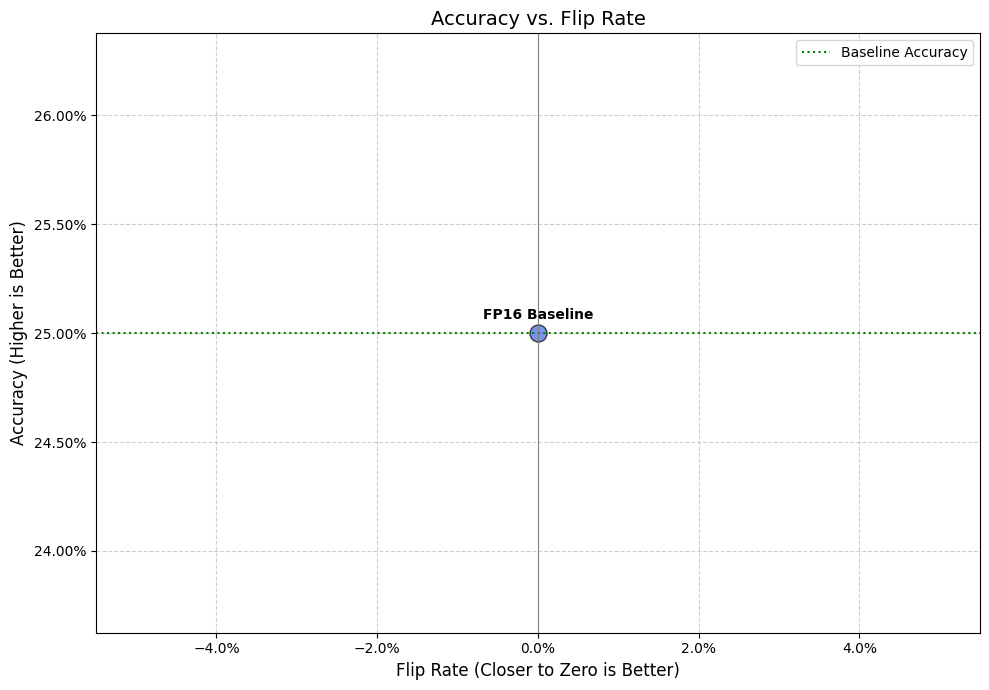

Plot saved as 'accuracy_vs_flips_flipped.png'


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 8. Visualization of Accuracy vs. Flip Rate ---

print("Generating Visualization...")

# Add FP16 Baseline to results for plotting
# `base_acc` is available from earlier execution in cell VMgnsLeIW4JT
if 'FP16 Baseline' not in results:
    results['FP16 Baseline'] = {'Acc': base_acc, 'Flip': 0.0}

# Extract data from the 'results' dictionary
# Ensure 'FP16 Baseline' is included in the order for the plot if desired
methods = list(results.keys())
accuracies = [results[m]['Acc'] for m in methods]
flip_rates = [results[m]['Flip'] for m in methods]

# Create the Scatter Plot
plt.figure(figsize=(10, 7))
# Swapping accuracies and flip_rates for x and y axes
plt.scatter(flip_rates, accuracies, s=150, c='royalblue', edgecolors='black', alpha=0.7, zorder=2)

# Annotate points with method names
for i, method in enumerate(methods):
    # Offset labels slightly to avoid overlap
    offset_y = 0.005 if i % 2 == 0 else -0.005
    plt.annotate(
        method,
        (flip_rates[i], accuracies[i]), # Swapped for annotation as well
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

# Formatting the Axes
plt.title('Accuracy vs. Flip Rate', fontsize=14)
plt.xlabel('Flip Rate (Closer to Zero is Better)', fontsize=12) # Swapped xlabel
plt.ylabel('Accuracy (Higher is Better)', fontsize=12) # Swapped ylabel

# Set percentage formatting for axes (swapped for x and y)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add grid and ideal region marker
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)
plt.axhline(base_acc, color='green', linestyle=':', label='Baseline Accuracy') # Now horizontal line for accuracy
plt.axvline(0, color='grey', linewidth=0.8) # Vertical line for 0 flip rate
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig('accuracy_vs_flips_flipped.png', dpi=300)
plt.show()

print("Plot saved as 'accuracy_vs_flips_flipped.png'")